In [ ]:
import os
from shutil import copyfile
import pymp2rage
import nibabel as nib
import nighres
from nilearn import plotting as niplt
from nilearn import image as niimg
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
datadrive = '/data00/'

finroot = datadrive + 'Ritu/ritu_7Tanalysis/'
foutroot = datadrive + 'lorenzo/PROJECTS/layers/rawdata/'

In [ ]:
subjects = [i for i in range(1,15)]
sessions = [1,2]
tasks = {1:'',2:'2',3:'3',4:'4'}

In [ ]:
if not os.path.isdir(fldin):
    fldin = finroot + 'S{:02d}_session{}/'.format(sub,ses)
    
os.path.isdir(fldin)


True

In [ ]:
df = pd.DataFrame()
for sub in subjects:
    for ses in [1,2]:
        
        overview = {'sub':sub,'ses':ses}
                
        fldin = finroot + 'S{:02d}session{}/'.format(sub,ses)
        if not os.path.isdir(fldin):
            fldin = finroot + 'S{:02d}_session{}/'.format(sub,ses)
            if not os.path.isdir(fldin):
                fldin = finroot + 'S{:02d}_session{}B/'.format(sub,ses)
        
        
        anat_fld = foutroot + 'sub-{:02d}/ses-{:02d}/anat/'.format(sub,ses)
        func_fld = foutroot + 'sub-{:02d}/ses-{:02d}/func/'.format(sub,ses)
        for fldout in [anat_fld,func_fld]:
            if not os.path.isdir(fldout):
                os.makedirs(fldout)

        # Process the anatomycal data
        froot_anat = anat_fld + 'sub-{:02d}_ses-{:02d}_'.format(sub,ses)                
        processed = process_anat(froot_anat,fldin)
        overview.update(processed)
        
        
        
        froot_func = func_fld + 'sub-{:02d}_ses-{:02d}_'.format(sub,ses)                
        processed = process_func(froot_func,fldin)
        overview.update(processed)
     
        
        
        df = df.append(pd.DataFrame([overview]),ignore_index = True)
#         except:
#             print('sub {} ses {} failed'.format(sub,ses))
            
            
        
df.to_csv(foutroot + 'data_overview.csv',index=False)

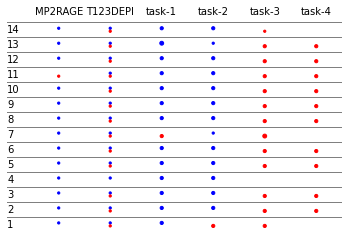

In [ ]:
for i,c in enumerate(df.columns[2:]):
    plt.scatter(i*np.ones(len(df))+1,df['sub'] - (df['ses']-1.5)/5, s = 5*df[c], c = df['ses'],cmap='bwr')
plt.xlim([0,6.5])
for s in subjects:
    plt.text(0,s,s,verticalalignment = 'center')
    plt.axhline(s+0.5,0,1,linewidth=1,color = 'gray')
for i,c in enumerate(df.columns[2:]):
    plt.text(i+1,s+1, c, horizontalalignment='center')

plt.axis('off')
plt.savefig(foutroot + 'data_overview.png',dpi=300)

In [ ]:
# 4 anni in bagno
# 47 anni tra computer e cellulare
# 26 anni dormire

In [ ]:
def process_func(file_root,in_dir):


    processed = {}
    for t in [1,2,3,4]:
        processed[f'task-{t}'] = 0
        filetype = 'func{}_'.format(tasks[t])

        file_list = []
        for subdir in os.listdir(in_dir):
            if (filetype in subdir)&(os.path.isdir(in_dir+subdir)):
                nscan = int(subdir.split('_')[-2])
                for f in os.listdir(in_dir+subdir):
                    if f.startswith('r'+subdir):
                        file_list.append([nscan,f'{subdir}/{f}'])

        file_list.sort()


        for i,(nscan,f) in enumerate(file_list):
            r = i+1
            processed[f'task-{t}'] += 1
            fout = file_root + f'task-{t}_run-{r}_bold.nii.gz'
            nib.load(in_dir + f).to_filename(fout)
            
            
    return processed

In [ ]:
def find_file_names(in_dir,filetype,matchnames):

    names = {}
    for subdir in os.listdir(in_dir):
        if filetype in subdir:
            for mn in matchnames:
                if (mn in subdir)&(os.path.isdir(in_dir+subdir)):
                    names[mn.lower()] = subdir
                    
    return names

In [ ]:
def process_anat(file_root,fld):

    acq = {'MP2RAGE':'full','T123DEPI':'part'}
    proc = {'MP2RAGE':1,'T123DEPI':1}
    
    for input_type in acq:
    
        try:
            names = find_file_names(fld,input_type,['INV1','INV2'])

            if input_type == 'MP2RAGE':
                data = {}
                for n in names:
                    data[f'{n}']   = fld + names[n] + f'/{names[n]}-t000.nii'
                    data[f'{n}ph'] = fld + names[n] + f'/{names[n]}-t003.nii'        

                for l in ['inv1','inv1ph','inv2','inv2ph']:
                    img = nib.load(data[l])
                    data[l] = file_root + f'acq-{acq[input_type]}_{l}.nii.gz' 
                    nib.save(img,data[l])


            elif input_type == 'T123DEPI':

                data = {}
                for n in names:
                    data[f'{n}_4D']   = fld + names[n] + f'/{names[n]}-t000-d0008.nii'
                    data[f'{n}ph_4D'] = fld + names[n] + f'/{names[n]}-t003-d0008.nii'

                to_keep = [0,1,3,5,7]

                for l in ['inv1','inv1ph','inv2','inv2ph']:
                    avg_img = niimg.math_img('np.average(img,axis = -1)',img = niimg.index_img(data[l+'_4D'],to_keep))
                    data[l] = file_root + f'acq-{acq[input_type]}_{l}.nii.gz' 
                    nib.save(avg_img,data[l])


            t1fit = nighres.intensity.mp2rage_t1_mapping([data['inv1'],data['inv1ph']], 
                                                 [data['inv2'],data['inv2ph']], 
                                                 [0.8,2.7],
                                                 [7.0,5.0],
                                                 5.5,
                                                 [0.0062, 0.0062],
                                                 160,
                                                 efficiency=0.96,
                                                 correct_B1=False,
                                                 B1_map=None,
                                                 scale_phase=True, 
                                                 save_data=False)

            labconv = {'T1w':'uni','T1map':'t1'}
            for l in ['T1w','T1map']:
                data[l] = file_root + f'acq-{acq[input_type]}_{l}.nii.gz' 
                nib.save(t1fit[labconv[l]],data[l])
                
        except:
            proc[input_type] = 0


    return proc